# Εκτίμηση κίνησης σε Βίντεο

## Ανοιγμα και επισκόπηση βίντεο
Διαχειριζόμαστε αρχείο βίντεο με OpenCV, με τον ίδιο τρόπο που διαχειριζόμαστε στατικές εικόνες (ή αρχεία εικόνων).

Η λογική μας είναι per-frame (ανά καρέ). Ανοίγουμε αρχικά το αρχείο video με την μέθοδο `cv2.VideoCapture()`, η οποία δέχεται σαν όρισμα ένα από τα παρακάτω:


*   path για το αρχείο video
*   device για capturing (id της κάμερας)

In [1]:
import cv2
import numpy as np

# video.mp4: input video
cap = cv2.VideoCapture("video.mp4")

while (cap.isOpened()):
  ret, frame = cap.read()

  cv2.imshow("A simple video player", frame)

  if cv2.waitKey(1) & 0xFF == ord('q'):
      break

cap.release()
cv2.destroyAllWindows()


error: OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/highgui/src/window.cpp:626: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Carbon support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvDestroyAllWindows'


Στον παραπάνω κώδικα, η συνάρτηση `read()` της κλάσης VideoCapture επιστρέφει το επόμενο frame, όσο υπάρχουν frames στο αρχείο ή στο stream. Η `ret` αποθηκεύει μια bool τιμή σχετική με το αποτέλεσμα.

Συμπεριφερόμαστε στο frame σαν σε μια κανονική εικόνα. Μπορούμε να την επεξεργαστούμε με OpenCV, numpy, scikit-image κλπ.

Η `cv2.waitKey()` περιμένει τον αριθμό των milliseconds που θα της δώσουμε, ή μέχρι να πατήσουμε το πλήκτρο που ορίζουμε στο `ord()` για να προχωρήσει στο επόμενο καρέ ή να κόψει το while-loop αντίστοιχα.

## Video properties

Με την `get()` της κλάσης VideoCapture, μπορούμε να πάρουμε πληροφορίες για το βίντεο, χρήσιμες για τη συνέχεια. Η μέθοδος αυτή δέχεται σαν όρισμα έναν ακέραιο ή ένα flag της OpenCV, που υποδηλώνει το property που θέλουμε να διαβάσουμε:

*   **cv2.CAP_PROP_FPS**: μας επιστρέφει τα FPS του βίντεο
*   **cv2.CAP_PROP_FRAME_WIDTH** και **cv2.CAP_PROP_FRAME_HEIGHT**: μας επιστρέφει το width και το height (columns και rows) του κάθε καρέ. Εναλλακτικά μπορούμε να χρησιμοποιήσουμε τη `frame.shape`.

Μπορείτε να βρείτε μια εξαντλητική λίστα των properties [εδώ](https://docs.opencv.org/2.4/modules/highgui/doc/reading_and_writing_images_and_video.html#videocapture-get). Στις τελευταίες εκδόσεις της python OpenCV, αφαιρείτε το αρχικό "CV_" από τα ονόματα των macros.

In [ ]:
cap = cv2.VideoCapture("shibuya.mp4")

print(cap.get(cv2.CAP_PROP_FPS))
print(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
print(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

ret, frame = cap.read()

print(frame.shape)

25.0
1280.0
720.0
(720, 1280, 3)


# Optical flow
Μέχρι στιγμής, έχουμε δει εφαρμογές που επεξεργάζονται μια εικόνα χωρικά, στο ίδιο frame. Τις ίδιες εφαρμογές μπορούμε να τις επεκτείνουμε και στο video.

Βέβαια, το video περιλαμβάνει και χρονική πληροφορίά. Δεν πρόκειται απλά για μια αλληλουχία άσχετων εικόνων. Έτσι, χρειαζόμαστε τρόπους για να ανιγνεύσουμε αυτή τη σχέση ανάμεσα στα frames.

![alt text](https://drive.google.com/uc?id=16_hfIQ5fr3S74Nz312UlufB0x4yfGs6f)

### Tι είναι το Optical flow
To πρόβλημα του optical flow μπορεί να οριστεί ως εξής:

<img src="https://drive.google.com/uc?id=1g0AKcxrxieA76espjs7ZeofFQjSfcxqZ" width="70%">

όπου, ανάμεσα σε διαδοχικά frames, εκφράζουμε την τιμή φωτεινότητας (I) συναρτήσει του χώρου (x,y) και του χρόνου (t).
$$I(x,y,t)=I(x+δx,y+δy,t+δt) $$

που με προσέγγιση Taylor γίνεται: $I(x+δx,y+δy,t+δt)=I(x,y,t)+\frac{\partial(I)}{\partial(x)}δx+\frac{\partial(I)}{\partial(y)}δy+\frac{\partial(I)}{\partial(t)}δt+...$ 
ή $\frac{\partial(I)}{\partial(x)}u+\frac{\partial(I)}{\partial(y)}v+\frac{\partial(I)}{\partial(t)}=0$

όπου $u=\frac{dx}{dt}$ και $v=\frac{dy}{dt}$, $\frac{dI}{dx}$, $\frac{dI}{dy}$ και $\frac{dI}{dt}$ είναι οι παράγωγοι της εικόνας ως προς τον οριζόντιο άξονα, τον κάθετο άξονα και το χρόνο. 


Έτσι, το πρόβλημα του optical flow καταλήγει στο να βρούμε τις "ταχύτητες" $u (\frac{dx}{dt})$ και $v (\frac{dy}{dt})$  για να καθορίσουμε την κίνηση στο χρόνο.

### Εύρεση χαρακτηριστικών για tracking.

Υπάρχουν δύο "σχολές" optical flow:


*   **Sparse optical flow (Αραιή οπτική ροή):** Παρακολούθηση συγκεκριμένων χαρακτηριστικών ενός frame στην πορεία του βίντεο
*   **Dense optical flow ((Πυκνή οπτική ροή):** Παρακολούθηση όλων των pixels του frame, στην πορεία του βίντεο

Η δεύτερη είναι πιο ακριβής αλλά και πιο υπολογιστικά ακριβή.

#### Sparse optical flow σε Shi-Tomasi features

Για την εφαρμογή του optical flow, παρακολουθούμε μόνο την κίνηση ενός σετ χαρακτηριστικών. Tα features στις εικόνες είναι σημεία ενδιαφέροντος που παρουσιάζουν πλούσιες πληροφορίες περιεχομένου εικόνας. Για παράδειγμα, τέτοια features μπορεί να είναι σημεία στην εικόνα που είναι αμετάβλητα στη μετάφραση, την κλίμακα, την περιστροφή και τις αλλαγές έντασης όπως οι γωνίες.

Ο Shi-Tomasi Corner Detector είναι πολύ παρόμοιος με τον γνωστό Harris Corner Detector. Ακολουθεί την παρακάτω διαδικασία:

*   Καθορισμός παραθύρων με μεγαλες κλίσεις (διακυμάνσεις στην ένταση της εικόνας) όταν υπάρχει μετατόπιση τόσο κατά την διεύθυνση του x και του y.

*   Για κάθε παράθυρο, υπολογίστε το score R
*   Ανάλογα με την τιμή του R, κάθε παράθυρο ταξινομείται ως επίπεδη περιοχή (δίχως διακυμάνσεις στην φωτεινότητα), άκρο ή γωνία.



![alt text](https://drive.google.com/uc?id=1Egv5GSlo4z8xR5S6_oHSrWC0DufFEvle)

O Shi-Tomasi detector θεωρείται ότι βελτιώνει τον Harris detector καθώς προσφέρει μια πιο robust και uniform αναπαράσταση των σχημάτων.

![alt text](https://drive.google.com/uc?id=1gItLF4m0CujefFkusEwGmeNsT5kuq6Lw)

### Ο αλγόριθμος Lucas-Kanade

Ο Lucas και ο Kanade πρότειναν μια αποτελεσματική τεχνική για την εκτίμηση της κίνησης των ενδιαφερόντων χαρακτηριστικών συγκρίνοντας δύο διαδοχικά καρέ. Η μέθοδος Lucas-Kanade λειτουργεί με τις ακόλουθες παραδοχές:

1. Δύο διαδοχικά καρέ χωρίζονται με μια μικρή αύξηση χρόνου (dt) έτσι ώστε τα αντικείμενα να μην εκτοπίζονται σημαντικά (με άλλα λόγια, η μέθοδος λειτουργεί καλύτερα με αντικείμενα με αργή κίνηση).
2. Ένα πλαίσιο απεικονίζει μια «φυσική» σκηνή αντικειμένων με αποχρώσεις του γκρι που αλλάζουν ομαλά.

Kάτω από αυτές τις υποθέσεις, μπορούμε να πάρουμε ένα μικρό παράθυρο 3x3 (γειτονιά) γύρω από τα χαρακτηριστικά που εντοπίστηκαν από τον Shi-Tomasi και να υποθέσουμε ότι και τα εννέα σημεία έχουν την ίδια κίνηση.

![alt text](https://drive.google.com/uc?id=1BiXITXWrPH-BWMN3bRSd_Iu0AtATt09y)

Αυτό είναι ένα set από 9 εξισώσεις, όπως αυτή που είδαμε στην αρχή:

$\begin{matrix}
  I_x(q_1)V_x+I_y(q_1)V_y=I_t(q_1)\\
  I_x(q_2)V_x+I_y(q_2)V_y=I_t(q_2)\\
  \vdots\\
  I_x(q_n)V_x+I_y(q_n)V_y=I_t(q_n)\\
 \end{matrix}$


Σε μορφή συστήματος, αυτό γίνεται:


$A=\begin{bmatrix}
  I_x(q_1)&&I_y(q_1)\\
  I_x(q_2)&&I_y(q_2)\\
  \vdots&&\vdots\\
  I_x(q_n)&&I_y(q_n)\\
 \end{bmatrix}\quad \quad$   $ u=\begin{bmatrix}V_x\\ V_y\end{bmatrix}\quad \quad$   $ b=\begin{bmatrix}-I_t(q_1)\\-I_t(q_2)\\ \vdots \\-I_t(q_n)\end{bmatrix}$

Ενώ στην αρχή είχαμε δύο αγνώστους (u και v) και μια εξίσωση, τώρα έχουμε δύο αγνώστους και 9 εξισώσεις!

Χρησιμοποιούμε least squares fitting για να λύσουμε το πρόβλημα του over-determination:

$\begin{bmatrix}
  V_x\\
  V_y\\
\end{bmatrix} \quad = 
\quad \begin{bmatrix}\sum_iI_x(q_i)^2 && \sum_iI_x(q_i)I_y(q_i)\\\sum_iI_y(q_i)I_x(q_i) && \sum_iI_y(q_i)^2 \end{bmatrix}
\quad \begin{bmatrix}-\sum_iI_x(q_i)I_t(q_i)\\-\sum_iI_y(q_i)I_t(q_i)\end{bmatrix}$


Με λίγα λόγια, εντοπίζουμε μερικά ενδιαφέροντα χαρακτηριστικά για παρακολούθηση και υπολογίζουμε επαναληπτικά τα διανύσματα optical flow αυτών των σημείων. Ωστόσο, η υιοθέτηση της μεθόδου Lucas-Kanade λειτουργεί μόνο για μικρές κινήσεις (από την αρχική μας υπόθεση) και αποτυγχάνει όταν υπάρχει μεγάλη κίνηση.

![alt text](https://drive.google.com/uc?id=1tkw2Btbi7ZdZg_mMk4shSYvieb1coxip)

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:2142: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if v not in values:


ValueError: ignored

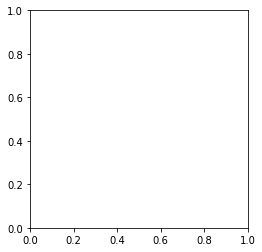

In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Parameters for Shi-Tomasi corner detection
feature_params = dict(maxCorners = 300, qualityLevel = 0.2, minDistance = 2, blockSize = 7)

# Parameters for Lucas-Kanade optical flow
lk_params = dict(winSize = (15,15), maxLevel = 2, criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))

cap = cv.VideoCapture("shibuya.mp4")

color = (0, 255, 0)

ret, first_frame = cap.read()

# Converts frame to grayscale because we only need the luminance channel for detecting edges - less computationally expensive
prev_gray = cv.cvtColor(first_frame, cv.COLOR_BGR2GRAY)

# Finds the strongest corners in the first frame by Shi-Tomasi method - we will track the optical flow for these corners
prev = cv.goodFeaturesToTrack(prev_gray, mask = None, **feature_params)

# Creates an image filled with zero intensities with the same dimensions as the frame - for later drawing purposes
mask = np.zeros_like(first_frame)

while(cap.isOpened()):

    ret, frame = cap.read()

    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

    # Calculates sparse optical flow by Lucas-Kanade method
    next, status, error = cv.calcOpticalFlowPyrLK(prev_gray, gray, prev, None, **lk_params)

    # Selects good feature points for previous position
    good_old = prev[status == 1]

    # Selects good feature points for next position
    good_new = next[status == 1]

    # Draws the optical flow tracks
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        # a, b = coordinates of new point
        a, b = new.ravel()

        # a, b = coordinates of old point
        c, d = old.ravel()

        # Draws line between new and old position with green color and 2 thickness
        mask = cv.line(mask, (a, b), (c, d), color, 2)

        # Draws filled circle (thickness of -1) at new position with green color and radius of 3
        frame = cv.circle(frame, (a, b), 3, color, -1)

    # Overlays the optical flow tracks on the original frame
    output = cv.add(frame, mask)

    # Updates previous frame
    prev_gray = gray.copy()

    # Updates previous good feature points
    prev = good_new.reshape(-1, 1, 2)

    # Opens a new window and displays the output frame
    plt.imshow("sparse optical flow", output)

    # Frames are read by intervals of 10 milliseconds. The programs breaks out of the while loop when the user presses the 'q' key
    if cv.waitKey(10) & 0xFF == ord('q'):
        break

# The following frees up resources and closes all windows
cap.release()
cv.destroyAllWindows()
